# ECG abnormality detector

## Authors
Sini Lähde <br>
Omar Nasri <br>
Juuso Torikka

### Objective

Objective of this notebook is to demonstrate arrhythmia 
detection from ECG signals. <br>
This notebook contains all relevant functions 
and functionalities for this project.

In [1]:
# imports
import os

import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import biosppy.signals.ecg as ecg
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.svm import SVC

from typing import Any

In [2]:
DATA_DIRECTORY = "data_sources"
NORMAL_DATA = "normal"
ABNORMAL_DATA = "abnormal"

In [3]:
def get_file_contents(file_path: str, classification: str) -> pd.DataFrame:
    """Process data file contents.

    Reads data from a specific .csv file and extracts the value column.
    The function splits filename to Subject ID part and and event number.
    These values are added to the dataframe along with classification label.

    Parameters
    ----------
    file_path : str
        Full file path to processed file.
    classification : str
        Classification label of the file.

    Returns
    -------
    pd.DataFrame
        Modified Pandas DataFrame

    """

    file_name = os.path.basename(file_path)
    subject_id, event_number = file_name.replace(".csv", "").split("_")[1:]
    subject_id = subject_id.replace("ID", "")

    data = pd.read_csv(file_path)

    data["event_number"] = event_number
    data["subject_id"] = subject_id
    if classification == NORMAL_DATA:
        data["label"] = 0
        return data
    data["label"] = 1
    return data


def get_directory_contents(directory: str, classification: str) -> pd.DataFrame:
    """Process all files in a directory.

    Iterates over all files in given directory. These files are passed to
    get_file_contents() function, which processes each file. Function combines
    all processed files into one Pandas DataFrame.

    Parameters
    ----------
    directory : str
        Root directory of the source data.
    classification : str
        Subdirectory in root, which indicates to correct classification.

    Returns
    -------
    pd.DataFrame
        Concatenated Pandas DataFrame of all files in same directory.

    """
    full_dataset = []
    directory = os.path.join(directory, classification)
    for file in os.listdir(directory):
        file_path = os.path.join(directory, file)
        data = get_file_contents(file_path=file_path, classification=classification)
        data.shape
        full_dataset.append(data)

    return pd.concat(full_dataset, ignore_index=True)


def combine_all_data() -> pd.DataFrame:
    """Combine all data into one DataFrame

    Functions calls processing tasks to get all the data together
    from their respective directories. Combines all these together.

    Returns
    -------
    pd.DataFrame
        Combined Normal and Abnormal data.

    """

    normal_data = get_directory_contents(DATA_DIRECTORY, NORMAL_DATA)
    print("Normal data has been processed\n")
    abnormal_data = get_directory_contents(DATA_DIRECTORY, ABNORMAL_DATA)
    print("Abnormal data has been processed\n")

    df = pd.concat([normal_data, abnormal_data], ignore_index=True)
    return df.sort_values(["subject_id", "event_number"])

In [4]:
df = combine_all_data()

Normal data has been processed

Abnormal data has been processed



In [5]:
display(df.head())

,Lead II,event_number,subject_id,label
0,-0.390,0,100,0
1,-0.395,0,100,0
2,-0.390,0,100,0
3,-0.405,0,100,0
4,-0.405,0,100,0


In [6]:
# Create a bandpass filter for signal filtering
def bandpass_filter(data, Fs):
    b, a = sp.signal.butter(4, [0.5, 40], btype="bandpass", fs=Fs)
    w, h = sp.signal.freqz(b, a, fs=Fs)
    return sp.signal.filtfilt(b, a, data)

In [7]:
def apply_z_score(data):
    return sp.stats.zscore(data)

In [8]:
# Create a dataframe for feature extraction
Fs = 360
df_features = pd.DataFrame(
    columns=[
        "subject_id",
        "event_number",
        "label",
        "qrs_duration",
        "qrs_amplitude",
        "ST_duration",
        "T_duration",
        "T_amplitude",
        "RR_interval",
    ]
)


# Function for calculating QRS durations
def calculate_qrs_durations(ecg: np.ndarray, rpeaks: np.ndarray, Fs: int) -> float:
    """Calculate mean duration of QRS in given signal

    Parameters
    ----------
    ecg : np.ndarray
        ECG signal.
    rpeaks : np.ndarray
        R-Peaks.
    Fs : int
        Frequency

    Returns
    -------
    float
        Mean duration of QRS complex.
    """
    filtered_qrs_durations = []
    smoothed_ecg = sp.signal.savgol_filter(ecg, window_length=5, polyorder=3)
    derivative = np.gradient(smoothed_ecg)
    s_wave_start_positions = []
    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        # Find the zero crossing before the R peak
        j = rpeak
        while j > 0:
            if derivative[j] > 0:
                j -= 1
            else:
                break
        # Find the zero crossing after the R peak
        k = rpeak
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break
        filtered_qrs_durations.append((k - j) / Fs)
        s_wave_start_positions.append(k / Fs)
    return np.mean(filtered_qrs_durations), s_wave_start_positions


def calculate_t_wave_features(ecg, rpeaks, Fs):
    t_amplitudes = []
    t_wave_timestamps = []
    # Set the delays after the rpeaks to get the t wave
    delay_start = int(0.05 * Fs)
    delay_end = int(0.4 * Fs)
    for i in range(len(rpeaks)):
        rpeak = rpeaks[i]
        gap_start = rpeak + delay_start
        gap_end = rpeak + delay_end
        gap_values = ecg[gap_start:gap_end]
        if len(gap_values) == 0:
            continue
        else:
            t_amplitude = np.max(gap_values)
            t_amplitudes.append(t_amplitude)
        # get the index of the max value in the gap to get the timestamp
        max_index = np.argmax(gap_values) + gap_start
        t_wave_timestamps.append(max_index)
    # Calculate the t wave durations
    t_wave_timestamps = pd.Series(t_wave_timestamps)
    # remove last t wave timestamp to avoid index out of range
    t_wave_timestamps = t_wave_timestamps[:-1]
    # Smooth the ecg to avoid getting stuck to local minimas
    smoothed_ecg = sp.signal.savgol_filter(ecg, window_length=5, polyorder=3)
    # Calc the derivative of the smoothed ecg
    derivative = np.gradient(smoothed_ecg)
    t_durations = []
    t_wave_start_positions = []

    # Get the start and end of the t wave using the derivative
    for i in range(len(t_wave_timestamps)):
        t_wave = t_wave_timestamps[i]
        j = t_wave - int(0.12 * Fs)
        while j < len(derivative):
            if derivative[j] > 0:
                j += 1
            else:
                break
        k = t_wave + int(0.15 * Fs)
        while k < len(derivative):
            if derivative[k] < 0:
                k += 1
            else:
                break
        t_durations.append((k - j) / Fs)
        t_wave_start_positions.append(j / Fs)
    # Return the mean t wave amplitude and duration and the start positions for ST duration calculation
    return np.mean(t_amplitudes), np.mean(t_durations), t_wave_start_positions


def calculate_st_duration(t_wave_start_positions, s_wave_start_positions):
    st_durations = []
    for i in range(len(t_wave_start_positions)):
        st_durations.append(t_wave_start_positions[i] - s_wave_start_positions[i])
    return np.mean(st_durations)


# Extract features from ECG signal
def extractFeatures(df: pd.DataFrame, Fs: int) -> pd.DataFrame:
    """Extract features from ECG signal

    Parameters
    ----------
    df : pd.DataFrame
        Signal to be processed
    Fs : int
        Frequency

    Returns
    -------
    pd.Dataframe

    """

    ten_second_sample = Fs * 10

    iterations = int(len(df) / ten_second_sample)
    for i in range(iterations):
        # Extract ECG signal
        ecg_signal = df["Lead II"].values[
            i * (ten_second_sample) : (i + 1) * (ten_second_sample)
        ]
        ecg_signal_filtered = bandpass_filter(ecg_signal, Fs)
        ecg_signal_filtered = apply_z_score(ecg_signal_filtered)

        # Extract R peaks
        rpeaks = ecg.hamilton_segmenter(signal=ecg_signal_filtered, sampling_rate=Fs)[0]
        # Extract mean RR interval
        rr_interval = np.mean(np.diff(rpeaks / Fs))

        # Extract QRS features
        qrs_amplitudes = [ecg_signal_filtered[rpeak] for rpeak in rpeaks]
        qrs_amplitude = np.mean(qrs_amplitudes)
        qrs_duration, s_start = calculate_qrs_durations(ecg_signal_filtered, rpeaks, Fs)

        # Extract T features
        t_duration, t_amplitude, t_start = calculate_t_wave_features(
            ecg_signal_filtered, rpeaks, Fs
        )

        # Extract ST features
        st_duration = calculate_st_duration(t_start, s_start)

        # Add features to dataframe
        df_features.loc[i] = [
            df["subject_id"][i * (ten_second_sample)],
            df["event_number"][i * (ten_second_sample)],
            df["label"][i * (ten_second_sample)],
            qrs_duration,
            qrs_amplitude,
            st_duration,
            t_duration,
            t_amplitude,
            rr_interval,
        ]
    return df_features

In [9]:
df_features = extractFeatures(df, Fs)

In [10]:
display(df_features.head())

,subject_id,event_number,label,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval
0,100,0,0,0.025694,7.027026,0.240909,0.213224,0.271970,0.819192
1,100,1,0,0.024573,6.808983,0.226389,0.208369,0.274306,0.806019
2,100,10,0,0.024537,6.935898,0.231061,0.222428,0.271970,0.807828
3,100,100,0,0.025427,6.759421,0.224769,0.178942,0.266898,0.793056
4,100,101,0,0.024306,6.959680,0.228535,0.192532,0.263131,0.800758


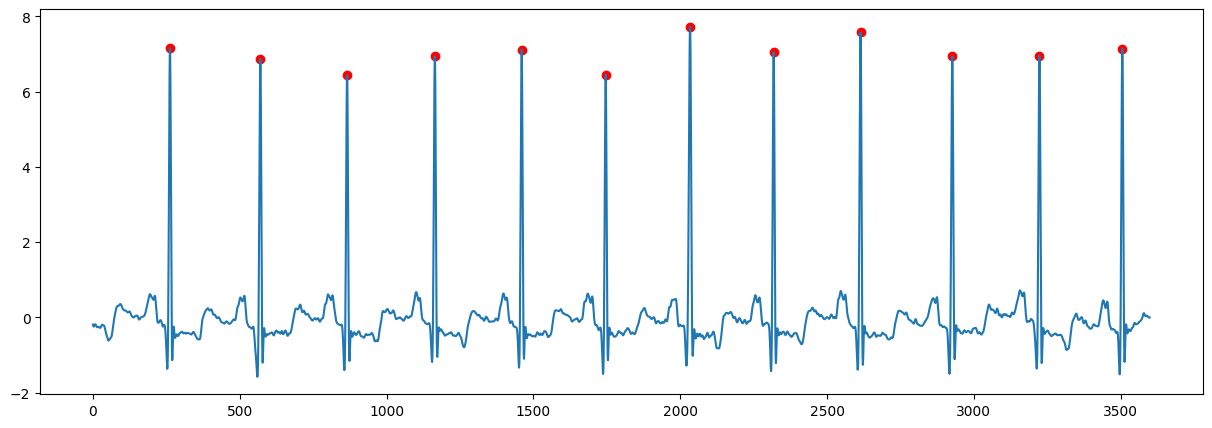

In [11]:
# Test ecg signal
test_ecg = df["Lead II"].values[: 10 * Fs]

# Filter the signal
test_ecg = bandpass_filter(test_ecg, Fs)

# Normalize the signal
test_ecg = apply_z_score(test_ecg)

# R peaks
rpeaks = ecg.hamilton_segmenter(test_ecg, sampling_rate=Fs)[0]

# T peaks
t_amplitude, t_duration, t = calculate_t_wave_features(test_ecg, rpeaks, Fs)

# plot the ecg signal with its r-peaks and t-peaks
plt.figure(figsize=(15, 5))
plt.plot(test_ecg)
plt.scatter(rpeaks, test_ecg[rpeaks], c="r")

# Modeling

### Pre-process for models

In [12]:
FEATURES = [
    "qrs_duration",
    "qrs_amplitude",
    "ST_duration",
    "T_duration",
    "T_amplitude",
    "RR_interval",
]
LABEL = "label"

features = df_features[FEATURES].values
labels = df_features[LABEL].values

total_metrics = {
    "SVM-Accuracy": [],
    "SVM-Precision": [],
    "SVM-Recall": [],
    "SVM-F1": [],
    "KNN-Accuracy": [],
    "KNN-Precision": [],
    "KNN-Recall": [],
    "KNN-F1": [],
}

In [13]:
X_train, X_temp, y_train, y_temp = train_test_split(
    features, labels, test_size=0.3, stratify=labels, random_state=42
)
X_test, X_unseen, y_test, y_unseen = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42
)

In [14]:
"""Initialize dataframe where predictions are added."""

predictions_df = pd.DataFrame(X_unseen, columns=FEATURES)
predictions_df["true_label"] = y_unseen

In [15]:
def _get_metrics(
    actual: np.ndarray, prediction: np.ndarray
) -> tuple[float, float, float, float, np.ndarray]:
    """Get model metrics.

    Parameters
    ----------
    actual: np.ndarray
        Actual labels.
    prediction: np.ndarray
        Predicted labels.

    Returns
    -------
    tuple[float, float, float, float, np.ndarray]
        Metrics: accuracy, precision, recall, f1, confusion matrix

    """

    accuracy = accuracy_score(actual, prediction)
    precision = precision_score(actual, prediction)
    recall = recall_score(actual, prediction)
    f1 = f1_score(actual, prediction)
    conf_matrix = confusion_matrix(actual, prediction)

    return accuracy, precision, recall, f1, conf_matrix

### Support Vector Machine (SVM)

In [47]:
def get_svm_classifier(X_train: np.ndarray, y_train: np.ndarray) -> Any:
    """Get SVM classifier.

    Trains SVM model and returns the model.

    Parameters
    ----------
    X_train: np.ndarray
        Train features.
    y_train: np.ndarray
        Train labels.

    Returns
    -------
    Any
        SVM-model

    """

    svm_classifier = SVC(kernel="rbf", random_state=42, gamma="auto", C=13)
    model = svm_classifier.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_test, predictions)

    print(
        f"SVM Metrics:\n\
    Accuracy: {accuracy:.4f}\n\
    Precision: {precision:.4f}\n\
    Recall: {recall:.4f}\n\
    F1 Score: {f1:.4f}\n\
    Confusion Matrix:\n{conf_matrix}"
    )

    return model

In [48]:
svm_classifier = get_svm_classifier(X_train, y_train)

SVM Metrics:
    Accuracy: 0.7945
    Precision: 0.7956
    Recall: 0.8096
    F1 Score: 0.8025
    Confusion Matrix:
[[625 178]
 [163 693]]


In [49]:
svm_predictions = svm_classifier.predict(X_unseen)
predictions_df["svm_predicted_label"] = svm_predictions

accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_unseen, svm_predictions)
total_metrics.update(
    {
        "SVM-Accuracy": accuracy,
        "SVM-Precision": precision,
        "SVM-Recall": recall,
        "SVM-F1": f1,
    }
)

print(
    f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}\nConfusion Matrix:\n{conf_matrix}"
)

Accuracy: 0.8089887640449438
Precision: 0.8083333333333333
Recall: 0.8128491620111732
F1: 0.8105849582172703
Confusion Matrix:
[[285  69]
 [ 67 291]]


### K-nn classifier

In [19]:
K_VALUES = [1, 3, 5, 7, 9, 11, 13, 15, 17]


def k_nn_classifier(
    X_train: np.ndarray, y_train: np.ndarray, k_values: list[int]
) -> int:
    """Train k-nn classifier.

    Trains K_nearest-neighbor classifier with specified K-values.
    Gets metrics for each k-value and returns the best K which can be used to train a new model.

    Parameters
    ----------
    X_train: np.ndarray
        Train features.
    y_train: np.ndarray
        Train labels.
    k_values: list[int]
        List of specified K-values to iterate.

    Returns
    -------
    int
        Best k-value.
    """
    metrics = {
        "K-value": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1": [],
    }

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)

        y_pred = knn.predict(X_test)

        accuracy, precision, recall, f1, _ = _get_metrics(y_test, y_pred)

        metrics["K-value"].append(k)
        metrics["Accuracy"].append(accuracy)
        metrics["Precision"].append(precision)
        metrics["Recall"].append(recall)
        metrics["F1"].append(f1)

    metrics_df = pd.DataFrame(metrics)
    best_k = metrics_df.loc[metrics_df["Recall"].idxmax()]
    best_k = int(best_k["K-value"])

    print(metrics_df)
    print(f"\nBest K-value based on recall: {best_k}")
    return best_k


best_k = k_nn_classifier(X_train, y_train, K_VALUES)

   K-value  Accuracy  Precision    Recall        F1
0        1  0.874020   0.888355  0.864486  0.876258
1        3  0.870404   0.885680  0.859813  0.872555
2        5  0.871609   0.890644  0.856308  0.873139
3        7  0.870404   0.891331  0.852804  0.871642
4        9  0.869198   0.894932  0.845794  0.869670
5       11  0.863773   0.893750  0.835280  0.863527
6       13  0.859554   0.886957  0.834112  0.859723
7       15  0.855937   0.888050  0.824766  0.855239
8       17  0.851115   0.877323  0.827103  0.851473

Best K-value based on recall: 1


In [20]:
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
knn_predictions = knn_final.predict(X_unseen)

In [21]:
accuracy, precision, recall, f1, conf_matrix = _get_metrics(y_unseen, knn_predictions)
total_metrics.update(
    {
        "KNN-Accuracy": accuracy,
        "KNN-Precision": precision,
        "KNN-Recall": recall,
        "KNN-F1": f1,
    }
)

print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall {recall}\nF1 {f1}")

print(f"\nConfusion Matrix:\n{conf_matrix}")

Accuracy: 0.8651685393258427
Precision: 0.8830409356725146
Recall 0.8435754189944135
F1 0.8628571428571428

Confusion Matrix:
[[314  40]
 [ 56 302]]


In [22]:
predictions_df["k_nn_predicted_label"] = knn_predictions
predictions_df

,qrs_duration,qrs_amplitude,ST_duration,T_duration,T_amplitude,RR_interval,true_label,svm_predicted_label,k_nn_predicted_label
0,0.042037,4.488716,0.228373,1.466010,0.150198,0.674206,1,1,1
1,0.028993,3.886878,0.120926,1.404889,0.255185,0.630556,1,1,1
2,0.038095,4.465087,0.219444,0.712549,0.260043,0.690385,0,1,0
3,0.025000,6.574189,0.176282,0.572939,0.268590,0.721154,1,1,1
4,0.021759,5.784952,0.061869,0.364909,0.270202,0.827525,1,1,1
...,...,...,...,...,...,...,...,...,...
707,0.055324,2.432740,0.300758,1.533862,0.161869,0.829798,1,0,0
708,0.031389,7.193404,0.198457,0.871768,0.241667,0.924383,1,0,1
709,0.045455,5.169972,0.272778,0.425073,0.190833,0.846667,0,0,1
710,0.053395,5.124924,0.131597,0.802216,0.263542,1.022917,0,0,0


In [23]:
total_metrics

{'SVM-Accuracy': 0.6896067415730337,
 'SVM-Precision': 0.6856368563685636,
 'SVM-Recall': 0.7067039106145251,
 'SVM-F1': 0.6960110041265475,
 'KNN-Accuracy': 0.8651685393258427,
 'KNN-Precision': 0.8830409356725146,
 'KNN-Recall': 0.8435754189944135,
 'KNN-F1': 0.8628571428571428}